In [66]:
import os
import numpy as np
import pandas as pd
from datetime import timedelta, datetime
from tqdm import tqdm

In [67]:
FORBES = './stock_market_data/forbes2000/csv/'
TICKER = 'ARCC'
PATH = os.path.join(FORBES, f"{TICKER}.csv")

In [68]:
df = pd.read_csv(PATH)
df['Date'] = pd.to_datetime(df['Date'])

In [69]:
df = df.drop(['Date'], axis=1)

In [73]:
data = df.to_numpy()
money = data[:, :4]
adj = data[:, 4:5]
volume = data[:, -1:]
x = np.hstack((money, adj, volume))

In [74]:
data[:, :3].shape

(4469, 3)

In [75]:
data.shape, x.shape

((4469, 6), (4469, 6))

In [10]:
df.describe()

,Low,Open,Volume,High,Close,Adjusted Close
count,4469.000000,4469.000000,4.469000e+03,4469.000000,4469.000000,4469.000000
mean,15.774003,15.948836,1.648042e+06,16.101493,15.942282,8.470200
std,3.093848,3.063429,1.529950e+06,3.024575,3.059745,5.128611
min,3.120000,3.270000,6.600000e+03,3.420000,3.210000,0.859628
25%,15.000000,15.160000,8.546000e+05,15.320000,15.170000,3.670892
50%,16.379999,16.520000,1.420800e+06,16.650000,16.510000,8.160035
75%,17.450001,17.570000,2.083300e+06,17.680000,17.580000,11.505618
max,22.430000,22.799999,2.882090e+07,23.000000,22.580000,22.580000


In [11]:
df = df[['Low', 'Open', 'High', 'Close', 'Adjusted Close', 'Volume']]

In [12]:
df.columns

Index(['Low', 'Open', 'High', 'Close', 'Adjusted Close', 'Volume'], dtype='object')

In [13]:
df.describe()

,Low,Open,High,Close,Adjusted Close,Volume
count,4469.000000,4469.000000,4469.000000,4469.000000,4469.000000,4.469000e+03
mean,15.774003,15.948836,16.101493,15.942282,8.470200,1.648042e+06
std,3.093848,3.063429,3.024575,3.059745,5.128611,1.529950e+06
min,3.120000,3.270000,3.420000,3.210000,0.859628,6.600000e+03
25%,15.000000,15.160000,15.320000,15.170000,3.670892,8.546000e+05
50%,16.379999,16.520000,16.650000,16.510000,8.160035,1.420800e+06
75%,17.450001,17.570000,17.680000,17.580000,11.505618,2.083300e+06
max,22.430000,22.799999,23.000000,22.580000,22.580000,2.882090e+07


In [16]:
import pickle, torch
from sklearn.preprocessing import MinMaxScaler

In [17]:
def get_all_csv_files(dir: str):
    files = []
    a = os.listdir(dir)
    for b in a:
        if os.path.isdir(os.path.join(dir, b)):
            c = os.path.join(dir, b, 'csv')
            if os.path.isdir(c):
                files += [os.path.join(c, f) for f in os.listdir(c) if f[-4:] == '.csv']

    return files

In [18]:
def large_df(files):
    return pd.concat((pd.read_csv(f) for i, f in tqdm(enumerate(files), total=len(files))), ignore_index=True)

In [19]:
files = get_all_csv_files('stock_market_data')
df = large_df(files)

100%|██████████| 4280/4280 [00:33<00:00, 126.32it/s]


In [29]:
df = df[['Low', 'Open', 'High', 'Close', 'Adjusted Close', 'Volume']].dropna()

In [50]:
DEFAULT_DATA_PATH = './stock_market_data'
SCALER_PATH = './scalers/minmax_scaler.bin'
VOLUME_SCALER_PATH = './scalers/volume_scaler.bin'

def make_scaler():
    print('=> Making scaler from all files')
    x = large_df(get_all_csv_files(DEFAULT_DATA_PATH))
    x = x.dropna(axis=0)
    x = x.drop(['Date'], axis=1)
    x = x[['Low', 'Open', 'High', 'Close', 'Adjusted Close', 'Volume']]
    x = x.to_numpy()
    
    scl = MinMaxScaler(feature_range=(0, 1))
    vscl = MinMaxScaler(feature_range=(0, 1))

    scl = scl.fit(x[:, :-1])
    vscl = vscl.fit(x[:, -1:])

    pickle.dump(scl, open(SCALER_PATH, 'wb'))
    pickle.dump(vscl, open(VOLUME_SCALER_PATH, 'wb'))

MONEY_RANGE = [0.0, 8324640145408.0]
ADJUSTED_RANGE = [-616456459764173628137646621458432.0, 942168706172424929960592932864.0]
VOLUME_RANGE = [0.0 ,7421640800.0]

def scale(data: torch.Tensor, new_min=0, new_max=1):
    money = data[:, :4]
    adj = data[:, 4:5]
    volume = data[:, -1:]

    money = (money - MONEY_RANGE[0]) / (MONEY_RANGE[1] - MONEY_RANGE[0]) * (new_max - new_min) + new_min
    adj = (adj - ADJUSTED_RANGE[0]) / (ADJUSTED_RANGE[1] - ADJUSTED_RANGE[0]) * (new_max - new_min) + new_min
    volume = (volume - VOLUME_RANGE[0]) / (VOLUME_RANGE[1] - VOLUME_RANGE[0]) * (new_max - new_min) + new_min
    return torch.hstack((money, adj, volume))

def inverse_scale(data: torch.Tensor, curr_min=0, curr_max=1):
    money = data[:, :4]
    adj = data[:, 4:5]
    volume = data[:, -1:]

    money = money * MONEY_RANGE[1]
    volume = volume * VOLUME_RANGE[1]

    adj = adj / curr_max * (ADJUSTED_RANGE[1] - ADJUSTED_RANGE[0]) + ADJUSTED_RANGE[0]

    return torch.hstack((money, adj, volume))

In [51]:
X = scale(torch.tensor(df.dropna().to_numpy()))

In [52]:
torch.max(X)

tensor(1., dtype=torch.float64)

In [53]:
XX = inverse_scale(X)

In [54]:
float(XX[:, 4].max()), df.values[:, 4].max()

(9.42168706172425e+29, 9.42168706172425e+29)

In [62]:
df.iloc[:, :-1].values.max(), df.iloc[:, 3:4].values.max()

(9.42168706172425e+29, 8324640145408.0)

In [152]:
np.linalg.norm(df.dropna().to_numpy()[:, :4])

136155042782240.69

In [156]:
XX = X[:, :4] * np.linalg.norm(136155042782240.69)

In [158]:
np.max(XX)

TypeError: max() received an invalid combination of arguments - got (axis=NoneType, out=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: axis, out
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: axis, out


torch.Size([8, 5]) torch.Size([5])
tensor(0.9985, dtype=torch.float64)
18.93000030517578


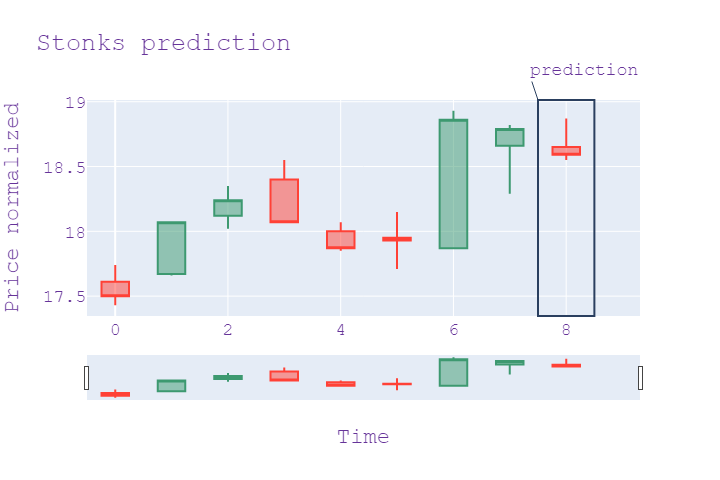

In [18]:
from lib.plots import make_candle_plot
from PIL import Image
import io, torch

c = make_candle_plot(torch.tensor(X[4460:4468, :-1], dtype=torch.float64), torch.tensor(X[4468, :-1], dtype=torch.float64))
im_c = Image.open(io.BytesIO(c))
im_c

In [64]:
np.hstack((X[:, :3], X[:, 3:4], X[:, -1:])).shape

(24351238, 5)

In [65]:
X.shape

torch.Size([24351238, 5])

In [21]:
iX = inverse_scale(X)

In [22]:
iX[:, :-1].max(), X.max()

(191466723344384.03, 2.1389836733272e+17)

In [14]:
def make_dataset(df: np.ndarray, time_d: int = 10):
    X, y = [], []

    for i in range(df.shape[0] - time_d - 1):
        idx = i + time_d
        row = df[idx + 1]
        row = row[:-1] # remove volume is it doesn't need to be predicted
        if np.isnan(np.sum(row)):
            continue

        x = df[i:idx]
        if np.isnan(np.sum(x)):
            continue # if the row (y) has nans, skip

        print(i, x, row)
        X.append(x)
        y.append(row)

        break
        
    return np.array(X), np.array(y)

In [15]:
X, y = make_dataset(df.to_numpy())

0 [[1.28347993e-01 1.28347993e-01 1.28905997e-01 1.28347993e-01
  1.00178480e-01 4.69033600e+08]
 [1.21652000e-01 1.22210003e-01 1.22210003e-01 1.21652000e-01
  9.49520767e-02 1.75884800e+08]
 [1.12723000e-01 1.13280997e-01 1.13280997e-01 1.12723000e-01
  8.79827887e-02 1.05728000e+08]
 [1.15512997e-01 1.15512997e-01 1.16071001e-01 1.15512997e-01
  9.01604369e-02 8.64416000e+07]
 [1.18862003e-01 1.18862003e-01 1.19419999e-01 1.18862003e-01
  9.27744359e-02 7.34496000e+07]
 [1.26115993e-01 1.26115993e-01 1.26673996e-01 1.26115993e-01
  9.84363481e-02 4.86304000e+07]
 [1.32254004e-01 1.32254004e-01 1.32813007e-01 1.32254004e-01
  1.03227161e-01 3.73632000e+07]
 [1.37834996e-01 1.37834996e-01 1.38393000e-01 1.37834996e-01
  1.07583262e-01 4.69504000e+07]
 [1.45089000e-01 1.45089000e-01 1.45647004e-01 1.45089000e-01
  1.13245167e-01 4.80032000e+07]
 [1.58482000e-01 1.58482000e-01 1.59040004e-01 1.58482000e-01
  1.23698667e-01 5.55744000e+07]] [0.156808   0.15736599 0.15736599 0.156808   0.

In [18]:
def scale(X, y):
    div = 255 / np.max(X)
    X *= div
    y *= div
    return X, y

In [2]:
files = get_all_csv_files('stock_market_data')
df = large_df(files)

NameError: name 'get_all_csv_files' is not defined

In [ ]:
df = large_df(files)

100%|██████████| 4280/4280 [00:35<00:00, 121.97it/s]


In [62]:
df.dropna(inplace=True)

In [66]:
df.max(), df.min()

(Date                                    31-12-2021
 Low                                8324640145408.0
 Open                               8324640145408.0
 Volume                                7421640800.0
 High                               8324640145408.0
 Close                              8324640145408.0
 Adjusted Close    942168706172424929960592932864.0
 dtype: object,
 Date                                       01-02-1971
 Low                                               0.0
 Open                                              0.0
 Volume                                            0.0
 High                                              0.0
 Close                                             0.0
 Adjusted Close   -616456459764173628137646621458432.0
 dtype: object)

In [70]:
df.iloc[:, 5:-1]

,Close
0,31.473534
1,28.880545
2,31.473534
3,28.612303
4,29.372318
...,...
24603266,173.919998
24603267,171.889999
24603268,174.210007
24603269,174.250000


In [65]:
df.Close.mean(), df['Adjusted Close'].mean()

(80678513.86284217, -6.683588104177315e+25)

In [37]:
df.iloc[:, :-1].values.min()

nan

In [60]:
df = df.where(df[['Low', 'Open', 'High', 'Close']] < df.mean() * 3).where(df[['Low', 'Open', 'High', 'Close']] > -1 * df.mean() * 3)

C:\Users\Seppe\AppData\Local\Temp\ipykernel_9172\3320255333.py:1: FutureWarning:

Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`



Low               23311562
Open              23307147
High              23308180
Close             23310432
Adjusted Close           0
Volume                   0
dtype: int64

In [85]:
np.max(df.drop(['Date'], axis=1).dropna().to_numpy())

9.42168706172425e+29

In [59]:
df.shape[0] - 24345889

5349

In [18]:
for file in files:
    if pd.read_csv(file).isnull().values.any():
        print(file)

stock_market_data\forbes2000\csv\ABTZY.csv
stock_market_data\forbes2000\csv\ADERY.csv
stock_market_data\forbes2000\csv\AET.csv
stock_market_data\forbes2000\csv\AFSI.csv
stock_market_data\forbes2000\csv\AUNB.csv
stock_market_data\forbes2000\csv\BHI.csv
stock_market_data\forbes2000\csv\BKRL.csv
stock_market_data\forbes2000\csv\BKUT.csv
stock_market_data\forbes2000\csv\CAA.csv
stock_market_data\forbes2000\csv\CBI.csv
stock_market_data\forbes2000\csv\CBUMF.csv
stock_market_data\forbes2000\csv\CCE.csv
stock_market_data\forbes2000\csv\CCGY.csv
stock_market_data\forbes2000\csv\CGYV.csv
stock_market_data\forbes2000\csv\CHNGQ.csv
stock_market_data\forbes2000\csv\COL.csv
stock_market_data\forbes2000\csv\CPFH.csv
stock_market_data\forbes2000\csv\CPICQ.csv
stock_market_data\forbes2000\csv\CTBK.csv
stock_market_data\forbes2000\csv\CTC.csv
stock_market_data\forbes2000\csv\ELROF.csv
stock_market_data\forbes2000\csv\ESRX.csv
stock_market_data\forbes2000\csv\GBNK.csv
stock_market_data\forbes2000\csv\GK

KeyboardInterrupt: 

In [8]:
df.shape

(24603272, 7)

In [9]:
from sklearn.preprocessing import MinMaxScaler
import pickle

scl = MinMaxScaler()
scl.fit(df.drop(['Date'], axis=1))

MinMaxScaler()

In [10]:
pickle.dump(scl, open('minmax_scaler.bin', 'wb'))

In [52]:
x = scl.transform(df.drop(['Date'], axis=1))

In [58]:
ddf = pd.DataFrame(x, columns=['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close'])

In [59]:
ddf.describe()

,Low,Open,Volume,High,Close,Adjusted Close
count,5.693000e+03,5.693000e+03,5693.000000,5.693000e+03,5.693000e+03,5693.000000
mean,5.124624e-12,5.191498e-12,0.000471,5.258447e-12,5.192594e-12,0.998474
std,3.987756e-12,4.031567e-12,0.000329,4.071758e-12,4.029249e-12,0.000000
min,9.022288e-13,9.194140e-13,0.000030,9.563624e-13,9.323030e-13,0.998474
25%,2.603574e-12,2.637945e-12,0.000269,2.676612e-12,2.643101e-12,0.998474
50%,3.569389e-12,3.623522e-12,0.000402,3.673360e-12,3.624382e-12,0.998474
75%,6.277749e-12,6.341415e-12,0.000582,6.417094e-12,6.331805e-12,0.998474
max,2.128260e-11,2.153607e-11,0.008428,2.157090e-11,2.153607e-11,0.998474


In [61]:
ddf[['Low', 'Open', 'High', 'Close', 'Adjusted Close', 'Volume']].describe()

,Low,Open,High,Close,Adjusted Close,Volume
count,5.693000e+03,5.693000e+03,5.693000e+03,5.693000e+03,5693.000000,5693.000000
mean,5.124624e-12,5.191498e-12,5.258447e-12,5.192594e-12,0.998474,0.000471
std,3.987756e-12,4.031567e-12,4.071758e-12,4.029249e-12,0.000000,0.000329
min,9.022288e-13,9.194140e-13,9.563624e-13,9.323030e-13,0.998474,0.000030
25%,2.603574e-12,2.637945e-12,2.676612e-12,2.643101e-12,0.998474,0.000269
50%,3.569389e-12,3.623522e-12,3.673360e-12,3.624382e-12,0.998474,0.000402
75%,6.277749e-12,6.341415e-12,6.417094e-12,6.331805e-12,0.998474,0.000582
max,2.128260e-11,2.153607e-11,2.157090e-11,2.153607e-11,0.998474,0.008428


In [18]:
df.iloc[:10].values[:, :5]

array([['18-11-1999', 28.612302780151367, 32.54649353027344, 62546380.0,
        35.765380859375],
       ['19-11-1999', 28.47818374633789, 30.713518142700195, 15234146.0,
        30.75822639465332],
       ['22-11-1999', 28.65700912475586, 29.551143646240234, 6577870.0,
        31.473533630371094],
       ['23-11-1999', 28.612302780151367, 30.40057182312012, 5975611.0,
        31.205293655395508],
       ['24-11-1999', 28.612302780151367, 28.701717376708984, 4843231.0,
        29.99821281433105],
       ['26-11-1999', 29.14878463745117, 29.23819732666016, 1729466.0,
        29.685264587402344],
       ['29-11-1999', 29.014663696289062, 29.327611923217773, 4074751.0,
        30.355865478515625],
       ['30-11-1999', 29.28290367126465, 30.042917251586918, 4310034.0,
        30.713518142700195],
       ['01-12-1999', 29.95350456237793, 30.177038192749023, 2957329.0,
        31.0711727142334],
       ['02-12-1999', 30.8923454284668, 31.29470634460449, 3069868.0,
        32.1888427734375]